# Cinematic Classification: Predicting Genres from Movie Posters

Script to classify movie posters.

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation


In [ ]:
# import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pathlib
import pandas as pd
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from keras.callbacks import LearningRateScheduler
from keras.preprocessing import image
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [ ]:
# Create a directory in the Colab environment to store the dataset
! mkdir /tmp/Multi_Label_dataset
# Copy the dataset images from Google Drive to the Colab environment
! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

        191.51M 100%  723.67kB/s    0:04:18 (xfr#7889, to-chk=0/7890)


In [ ]:
# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [ ]:
###Function to process images: convert to float32 and resize to 64x64 pixels.

def img_process(image, label):
    # Convert image to float32 datatype
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize image to 64x64 pixels
    image = tf.image.resize(image, [64, 64])

    return image, label

**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
## Load training and validation data efficiently using tf.data API.

# Define batch size
batch_size = 64

# Create training dataset
train_ds = train_list_ds.map(parse_image)\
                       .map(img_process)\
                       .cache()\
                       .shuffle(buffer_size=len(labels_train))\
                       .batch(batch_size)\
                       .prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_ds = test_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)\
                     .batch(batch_size)\
                     .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)\
                     .cache()\
                     .prefetch(tf.data.AUTOTUNE)

# Model Definition


**Define a convolutional neural network using the Keras Functional API with the specified architecture.**

**Important points:**

* Use ReLU activation functions for convolutional layers and the first dense layer.
* Use Sigmoid activation function for the output layer.
* Pay attention to output shapes and parameters as indicated in the model summary.
* Apply a dropout rate of 0.2 after convolutional layers and 0.5 after dense layers.
"""


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
### Define the model using the Keras Functional API.

# Define the input layer
input_layer = keras.layers.Input(shape=(64, 64, 3), name='Input')

# First Conv Block
conv0 = keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu', name='Conv0')(input_layer)
drop1 = keras.layers.Dropout(0.2, name='Drop1')(conv0)

# Second Conv Block
conv1 = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv1')(drop1)
conv2 = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='Conv2')(conv1)
drop2 = keras.layers.Dropout(0.2, name='Drop2')(conv2)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='Pool1')(drop2)

# Third Conv Block
conv3 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv3')(pool1)
conv4 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='Conv4')(conv3)
drop3 = keras.layers.Dropout(0.2, name='Drop3')(conv4)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='Pool2')(drop3)

# Fourth Conv Block
conv5 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv5')(pool2)
conv6 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='Conv6')(conv5)
drop4 = keras.layers.Dropout(0.5, name='Drop4')(conv6)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), name='Pool3')(drop4)

# Flattening followed by Dense layers
flat = keras.layers.Flatten(name='Flat')(pool3)
fc1 = keras.layers.Dense(1024, activation='relu', name='FC1')(flat)
drop5 = keras.layers.Dropout(0.5, name='Drop5')(fc1)
fc2 = keras.layers.Dense(1024, activation='relu', name='FC2')(drop5)
drop6 = keras.layers.Dropout(0.5, name='Drop6')(fc2)

# Output layer
output_layer = keras.layers.Dense(25, activation='sigmoid', name='Output')(drop6)

# Create Model
model = keras.Model(inputs=input_layer, outputs=output_layer, name='model')

In [ ]:
# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0     

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[Precision(), Recall()])

# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [ ]:
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoint'

# Create ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True,
                                      verbose=1)

**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Create LearningRateScheduler callback
lr_callback = LearningRateScheduler(scheduler, verbose=1)


**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
### Train the model for 40 epochs, using the callbacks you have created. Store the losses and metrics in a history object.

# Define the number of epochs
epochs = 40

# Train the model with callbacks
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[checkpoint_callback, lr_callback])

# Store the losses and metrics
losses = history.history['loss']
val_losses = history.history['val_loss']
precisions = history.history['precision']
recalls = history.history['recall']


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 0.3266 - precision: 0.3323 - recall: 0.2060
Epoch 1: val_loss improved from inf to 0.32686, saving model to /content/checkpoint
91/91 [==============================] - 18s 59ms/step - loss: 0.3266 - precision: 0.3323 - recall: 0.2060 - val_loss: 0.3269 - val_precision: 0.5614 - val_recall: 0.0096 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
89/91 [============================>.] - ETA: 0s - loss: 0.2616 - precision: 0.4642 - recall: 0.1576
Epoch 2: val_loss improved from 0.32686 to 0.30954, saving model to /content/checkpoint
91/91 [==============================] - 3s 33ms/step - loss: 0.2613 - precision: 0.4640 - recall: 0.1573 - val_loss: 0.3095 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.99

# Model Evaluation

**Generate plots to evaluate model performance and critically analyze the results.**

**Visualize classification performance with multi-label comparison of predicted vs. ground truth genres.**
"""

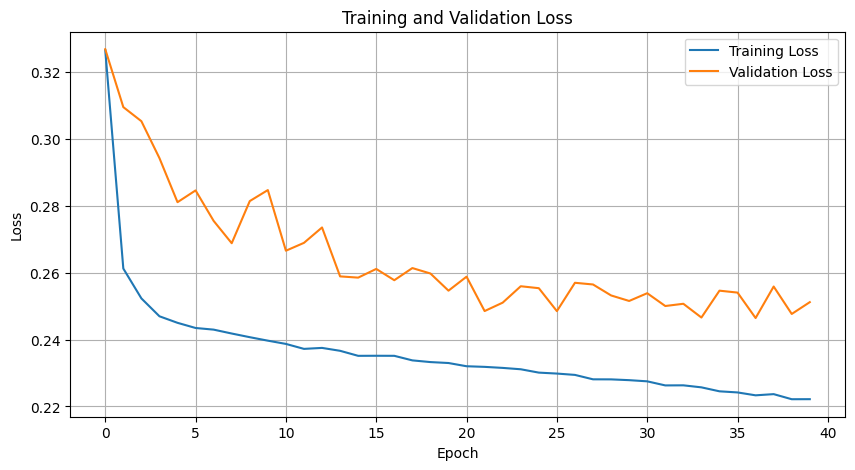

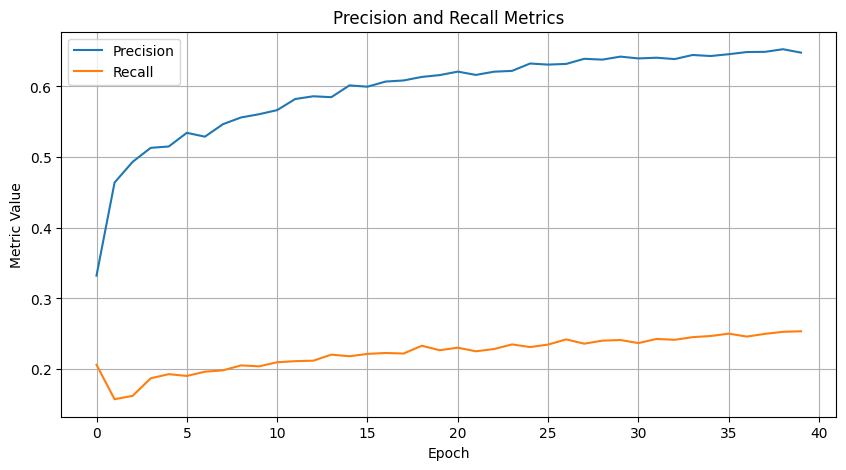

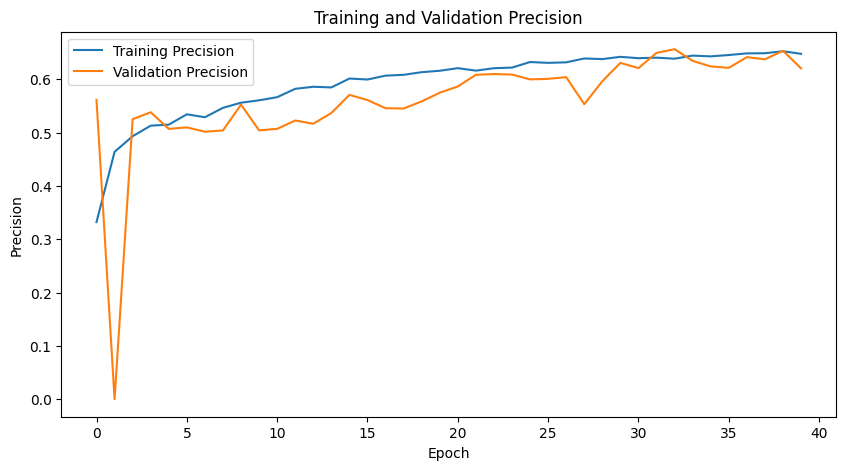

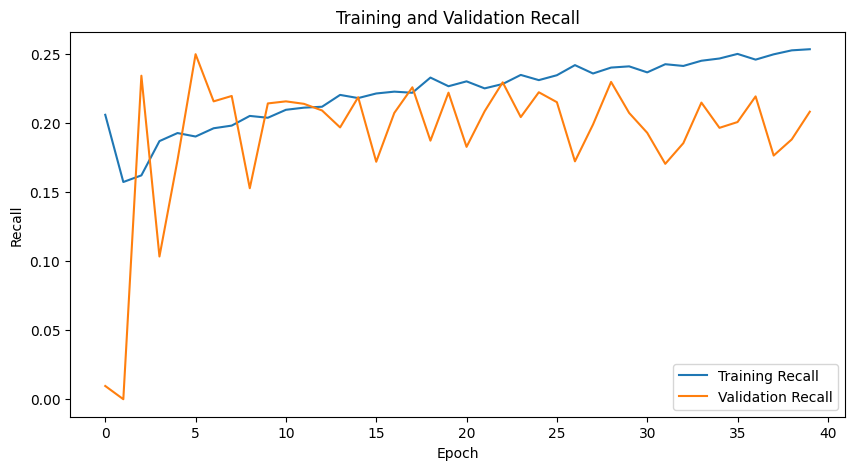

In [ ]:
# CodeGrade Tag Ex4a

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision and recall metrics
plt.figure(figsize=(10, 5))
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.title('Precision and Recall Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster.**

23/23 [==============================] - 0s 9ms/step - loss: 0.2595 - precision: 0.5696 - recall: 0.1683
Precision: 0.569556474685669
Recall: 0.16825491189956665
F1-score: 0.25977011526913907


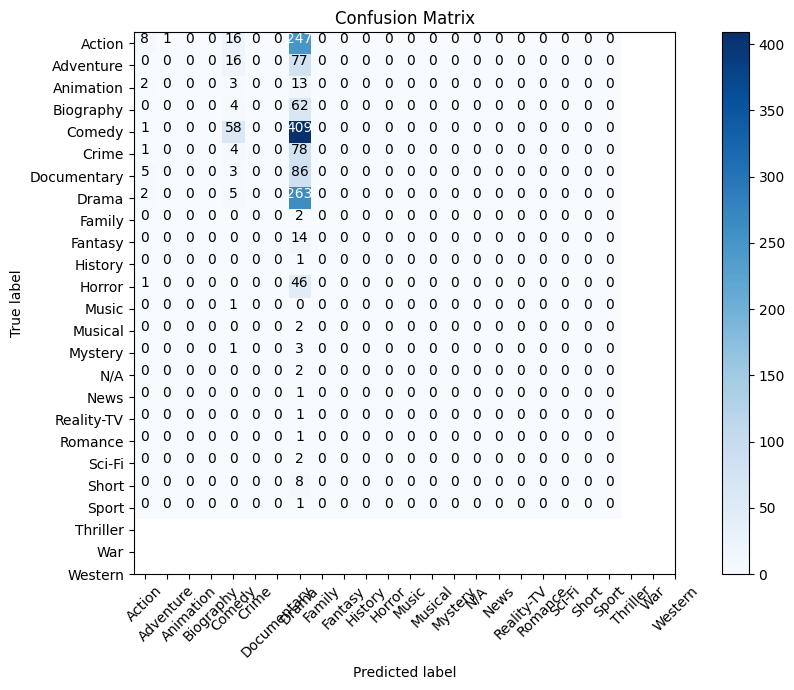

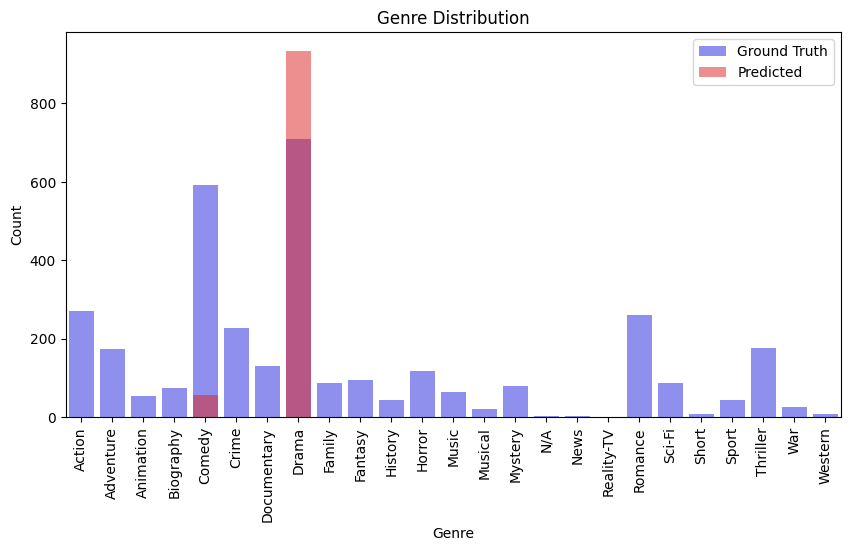

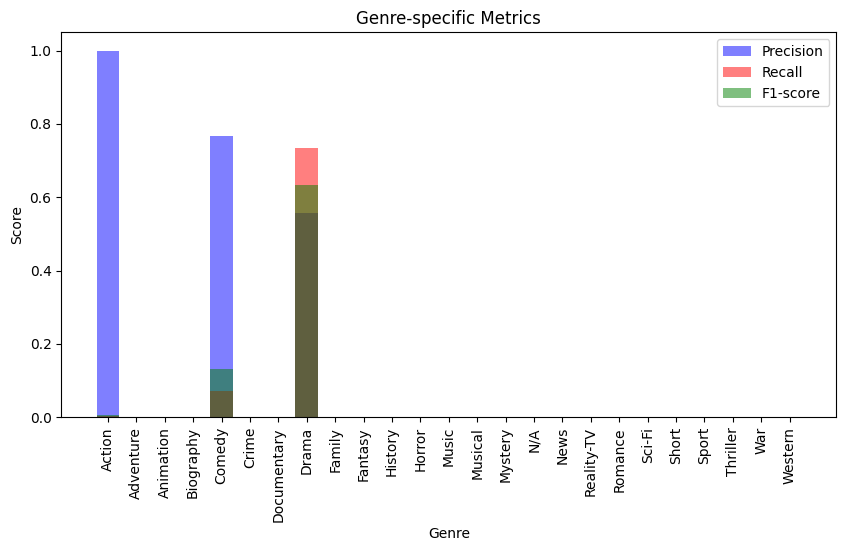

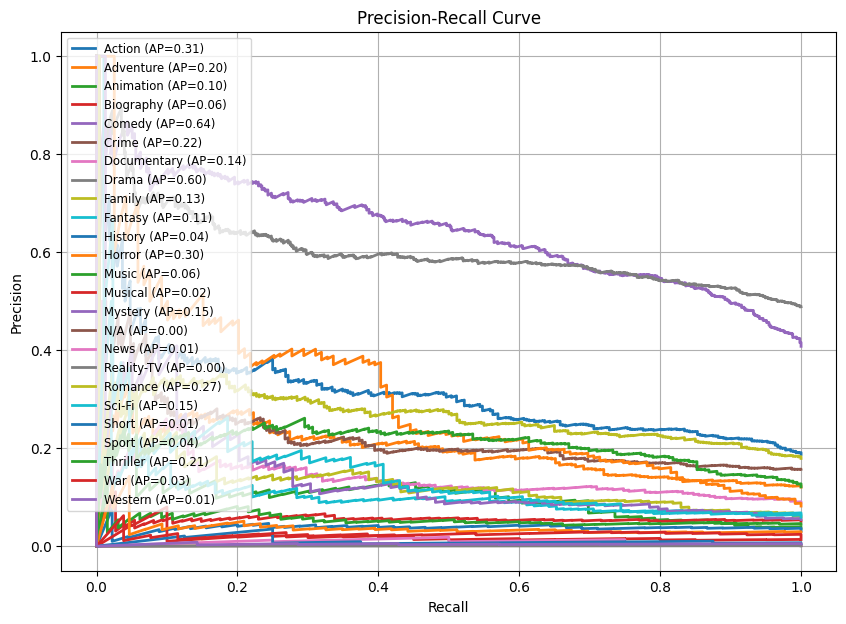

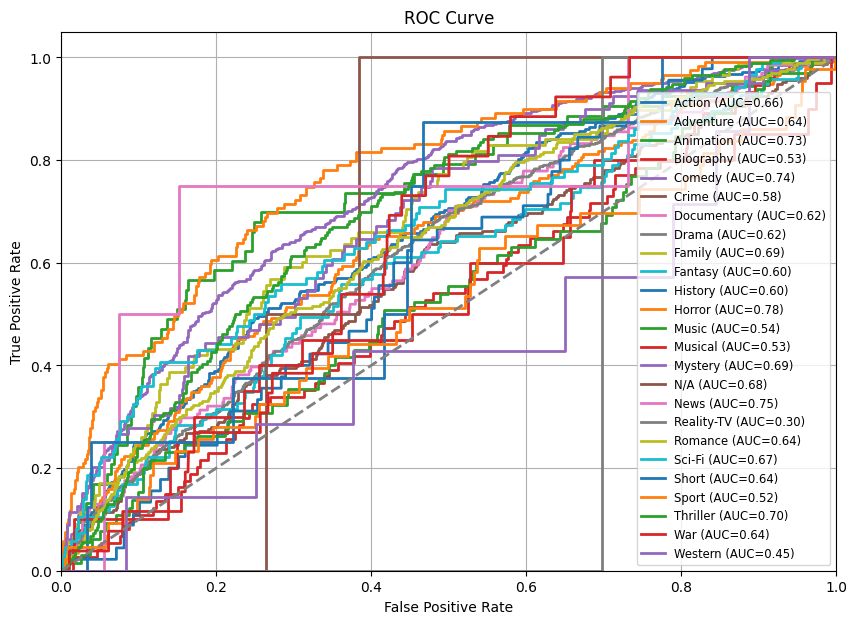

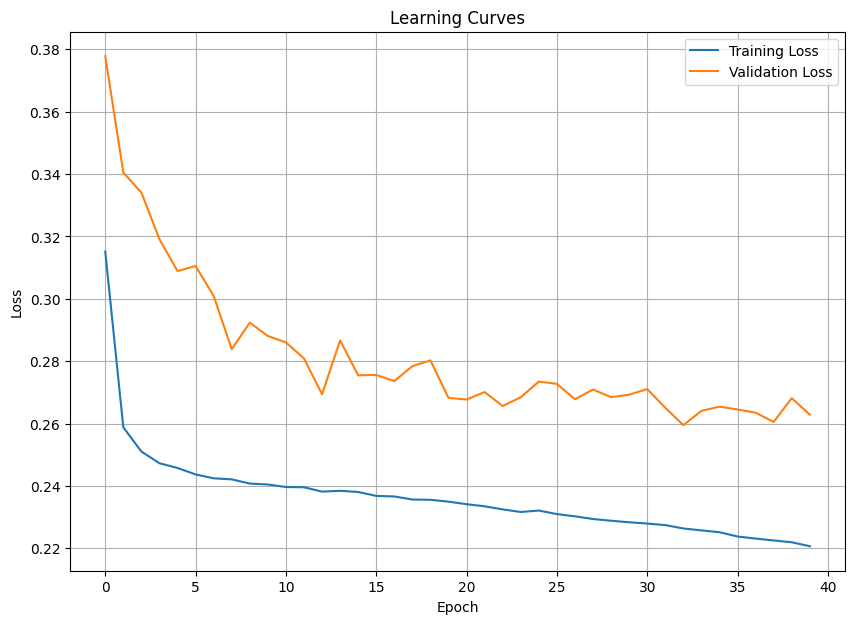

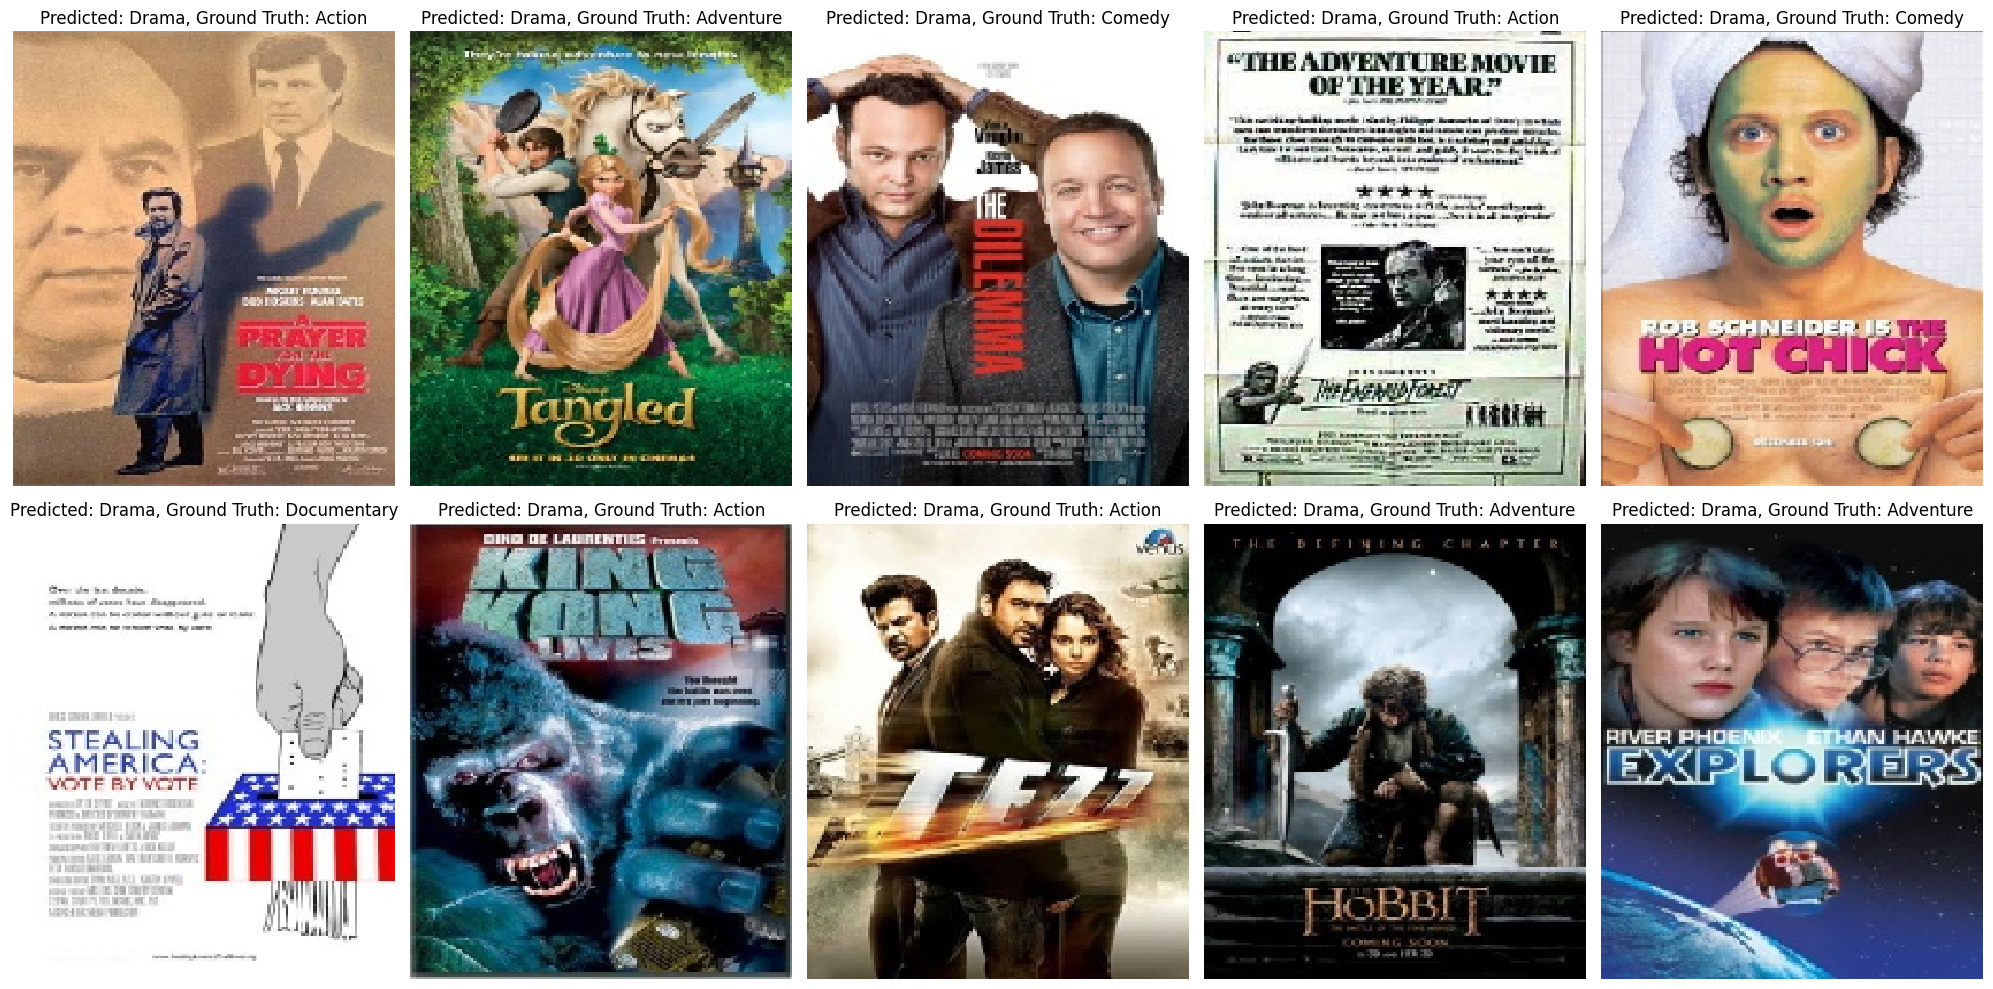

In [ ]:
# CodeGrade Tag Ex4b
# Load the best weights from the model checkpoint
model.load_weights(checkpoint_filepath)

# Make predictions on the validation dataset
predictions = model.predict(val_ds)

# Compare the predicted genres with the ground truth genres for each poster
# For example, you can calculate the top three most probable genres for each poster
top_predicted_genres = np.argsort(-predictions, axis=1)[:, :3]  # Get indices of top three predicted genres
ground_truth_genres = labels_test  # Assuming labels_test contains ground truth genres

# Evaluate the model on the test dataset
scores = model.evaluate(val_ds)

# Extract precision, recall, and F1-score
precision = scores[1]
recall = scores[2]
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Calculate and print confusion matrix

# Get true labels and predictions
y_true = np.argmax(labels_test, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(ground_truth_genres, axis=1), np.argmax(predictions, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(genres))
plt.xticks(tick_marks, genres, rotation=45)
plt.yticks(tick_marks, genres)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add text annotations
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Bar Plot of Genre Distribution

# Count the occurrences of each genre in ground truth labels and predicted labels
ground_truth_counts = np.sum(ground_truth_genres, axis=0)
predicted_counts = np.sum(predictions > 0.5, axis=0)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=genres, y=ground_truth_counts, color='blue', alpha=0.5, label='Ground Truth')
sns.barplot(x=genres, y=predicted_counts, color='red', alpha=0.5, label='Predicted')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Examples of Predicted vs. Ground Truth Genres
# Choose some random movie posters and display their predicted and ground truth genres along with the images

# Genre-specific Metrics
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for each genre
precision, recall, f1_score, _ = precision_recall_fscore_support(ground_truth_genres, predictions > 0.5, average=None, labels=range(len(genres)))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(genres, precision, color='blue', alpha=0.5, label='Precision')
plt.bar(genres, recall, color='red', alpha=0.5, label='Recall')
plt.bar(genres, f1_score, color='green', alpha=0.5, label='F1-score')
plt.title('Genre-specific Metrics')
plt.xlabel('Genre')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(genres)):
    precision[i], recall[i], _ = precision_recall_curve(ground_truth_genres[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(ground_truth_genres[:, i], predictions[:, i])

# Plot precision-recall curve
plt.figure(figsize=(10, 7))
for i in range(len(genres)):
    plt.plot(recall[i], precision[i], lw=2, label='{0} (AP={1:0.2f})'.format(genres[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

# ROC Curve

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(genres)):
    fpr[i], tpr[i], _ = roc_curve(ground_truth_genres[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(genres)):
    plt.plot(fpr[i], tpr[i], lw=2, label='{0} (AUC={1:0.2f})'.format(genres[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

# Learning Curves
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis
# Identify misclassified examples and visualize them along with their predicted and ground truth labels

# Find misclassified examples
misclassified_indices = np.where(np.argmax(predictions, axis=1) != np.argmax(ground_truth_genres, axis=1))[0]

# Display misclassified examples
num_examples_to_display = min(len(misclassified_indices), 10)  # Display up to 10 misclassified examples
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=2.0, wspace=2.0)
for i, idx in enumerate(misclassified_indices[:num_examples_to_display]):
    plt.subplot(2, 5, i + 1)
    img = tf.keras.preprocessing.image.load_img(img_locs_test[0][idx], target_size=(200, 200))  # Resize image
    plt.imshow(img, interpolation='nearest', aspect='auto')
    plt.title(f'Predicted: {genres[np.argmax(predictions[idx])]}, Ground Truth: {genres[np.argmax(ground_truth_genres[idx])]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
